In [1]:
import numpy as np
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import os
import itertools
import h5py


from model.mlp import MLP
from tools.train_double_logistic import double_logistic_function, H5Dataset
from utils.helpers import get_doy, check_missing_timestamps

In [2]:
OUTLIER_FACTOR = 1.5
OUTLIER_FACTOR_NN = 1.5
MAX_MISSINGNESS = 0.95
COUNT_THRESHOLD = 100
WINDOW_SIZE = 3
T_WINDOW_SIZE = 5
NUM_YEARS = 7
NUM_DATAPOINTS_PER_YEAR = 73
H = 128
W = 128
START_YEAR = 2017
END_YEAR = 2023

In [3]:
PATH = "/data_1/scratch_1/processed/nn_dataset_v2.h5"
YEARS_IN_TRAIN = 6  # first six years in train, last year in test
SPLIT_IDX = NUM_DATAPOINTS_PER_YEAR * YEARS_IN_TRAIN
T_SCALE = 1.0 / 365.0
BATCH_SIZE = 2048
t_plot = torch.linspace(0, 365, 1000).unsqueeze(0) * T_SCALE
device = "cuda"

features = ["lon", "lat", "dem", "fc", "fh", "slope", "easting", "northing", "twi", "rugg", "curv"]
ds = H5Dataset(PATH, features)
loader = DataLoader(ds, batch_size=BATCH_SIZE, drop_last=False, shuffle=False, num_workers=32)

In [27]:

encoder = MLP(d_in=len(ds.features), d_out=8, n_blocks=8, d_block=256, dropout=0, skip_connection=True).to(device)
encoder.load_state_dict(torch.load("/data_1/scratch_1/dbrueggemann/nn/encoder_all_500k.pt"))
encoder.eval()

MEANS = {
    "lon": 8.34458,
    "lat": 46.32019,
    "dem": 1104.5027,
    "fc": 43.102547,
    "fh": 15.638395,
    "slope": 26.418936,
    "easting": -0.0069493465,
    "northing": 0.062305786,
    "twi": 2.8649843,
    "rugg": 8.363732,
    "curv": 6.1888146e-05,
}
STDS = {
    "lon": 0.9852665,
    "lat": 0.61929077,
    "dem": 409.8894,
    "fc": 40.840992,
    "fh": 30.395235,
    "slope": 13.358144,
    "easting": 0.69276434,
    "northing": 0.7184338,
    "twi": 1.861385,
    "rugg": 5.4581103,
    "curv": 0.0061930786,
}

means_pt = torch.tensor([MEANS[f] for f in ds.features]).to(device).unsqueeze(0)
stds_pt = torch.tensor([STDS[f] for f in ds.features]).to(device).unsqueeze(0)

train_below = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
train_in = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
train_above = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)

test_below = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
test_in = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)
test_above = np.zeros(NUM_DATAPOINTS_PER_YEAR, dtype=int)

for i, sample in enumerate(loader):
        
    with torch.no_grad():

        ndvi, doy, inp = sample
        # nan_mask = torch.isnan(ndvi)

        bs = ndvi.shape[0]

        # separate into train/test
        ndvi_train = ndvi[:, :SPLIT_IDX].to(device)
        doy_train = doy[:, :SPLIT_IDX].to(device)
        # nan_mask_train = nan_mask[:, :SPLIT_IDX]

        ndvi_test = ndvi[:, SPLIT_IDX:].to(device)
        doy_test = doy[:, SPLIT_IDX:].to(device)
        # nan_mask_test = nan_mask[:, -SPLIT_IDX:]

        inp = inp.float().to(device)

        # standardize input
        inp = (inp - means_pt) / stds_pt

        # impute possible missing values with mean (should be the case only for fc)
        inp = torch.nan_to_num(inp, nan=0.0)

        preds = encoder(inp.float())
        paramsl = preds[:, [0, 1, 2, 3, 4, 5]]
        paramsu = torch.cat([preds[:, [0, 1, 2, 3]], preds[:, [4, 5]] + nn.functional.softplus(preds[:, [6, 7]])], axis=1)

        t_train = (doy_train * T_SCALE).to(device)
        ndvi_lower_pred_train = double_logistic_function(t_train, paramsl)
        ndvi_upper_pred_train = double_logistic_function(t_train, paramsu)

        ndvi_lower_pred_train = ndvi_lower_pred_train.view(bs, YEARS_IN_TRAIN, NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
        ndvi_upper_pred_train = ndvi_upper_pred_train.view(bs, YEARS_IN_TRAIN, NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
        ndvi_train = ndvi_train.view(bs, YEARS_IN_TRAIN, NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
        ndvi_train_mask = ~torch.isnan(ndvi_train)

        train_below += torch.sum((ndvi_train < ndvi_lower_pred_train) * ndvi_train_mask, dim=0).cpu().numpy()
        train_in += torch.sum(((ndvi_train >= ndvi_lower_pred_train) & (ndvi_train <= ndvi_upper_pred_train)) * ndvi_train_mask, dim=0).cpu().numpy()
        train_above += torch.sum((ndvi_train > ndvi_upper_pred_train) * ndvi_train_mask, dim=0).cpu().numpy()
        # train_below.append(torch.sum((ndvi_train < ndvi_lower_pred_train) * ndvi_train_mask, dim=0) / torch.sum(ndvi_train_mask, dim=0))
        # train_in.append(torch.sum(((ndvi_train >= ndvi_lower_pred_train) & (ndvi_train <= ndvi_upper_pred_train)) * ndvi_train_mask, dim=0) / torch.sum(ndvi_train_mask, dim=0))
        # train_above.append(torch.sum((ndvi_train > ndvi_upper_pred_train) * ndvi_train_mask, dim=0) / torch.sum(ndvi_train_mask, dim=0))

        t_test = (doy_test * T_SCALE).to(device)
        ndvi_lower_pred_test = double_logistic_function(t_test, paramsl)
        ndvi_upper_pred_test = double_logistic_function(t_test, paramsu)

        ndvi_lower_pred_test = ndvi_lower_pred_test.view(bs, 1, NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
        ndvi_upper_pred_test = ndvi_upper_pred_test.view(bs, 1, NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
        ndvi_test = ndvi_test.view(bs, 1, NUM_DATAPOINTS_PER_YEAR).contiguous().view(-1, NUM_DATAPOINTS_PER_YEAR)
        ndvi_test_mask = ~torch.isnan(ndvi_test)

        test_below += torch.sum((ndvi_test < ndvi_lower_pred_test) * ndvi_test_mask, dim=0).cpu().numpy()
        test_in += torch.sum(((ndvi_test >= ndvi_lower_pred_test) & (ndvi_test <= ndvi_upper_pred_test)) * ndvi_test_mask, dim=0).cpu().numpy()
        test_above += torch.sum((ndvi_test > ndvi_upper_pred_test) * ndvi_test_mask, dim=0).cpu().numpy()
        # test_below.append(torch.sum((ndvi_test < ndvi_lower_pred_test) * ndvi_test_mask, dim=0) / torch.sum(ndvi_test_mask, dim=0))
        # test_in.append(torch.sum(((ndvi_test >= ndvi_lower_pred_test) & (ndvi_test <= ndvi_upper_pred_test)) * ndvi_test_mask, dim=0) / torch.sum(ndvi_test_mask, dim=0))
        # test_above.append(torch.sum((ndvi_test > ndvi_upper_pred_test) * ndvi_test_mask, dim=0) / torch.sum(ndvi_test_mask, dim=0))

        if (i + 1) % 1000 == 0:
            print("done {} iterations".format(i))


done 999 iterations
done 1999 iterations
done 2999 iterations
done 3999 iterations
done 4999 iterations
done 5999 iterations
done 6999 iterations
done 7999 iterations
done 8999 iterations


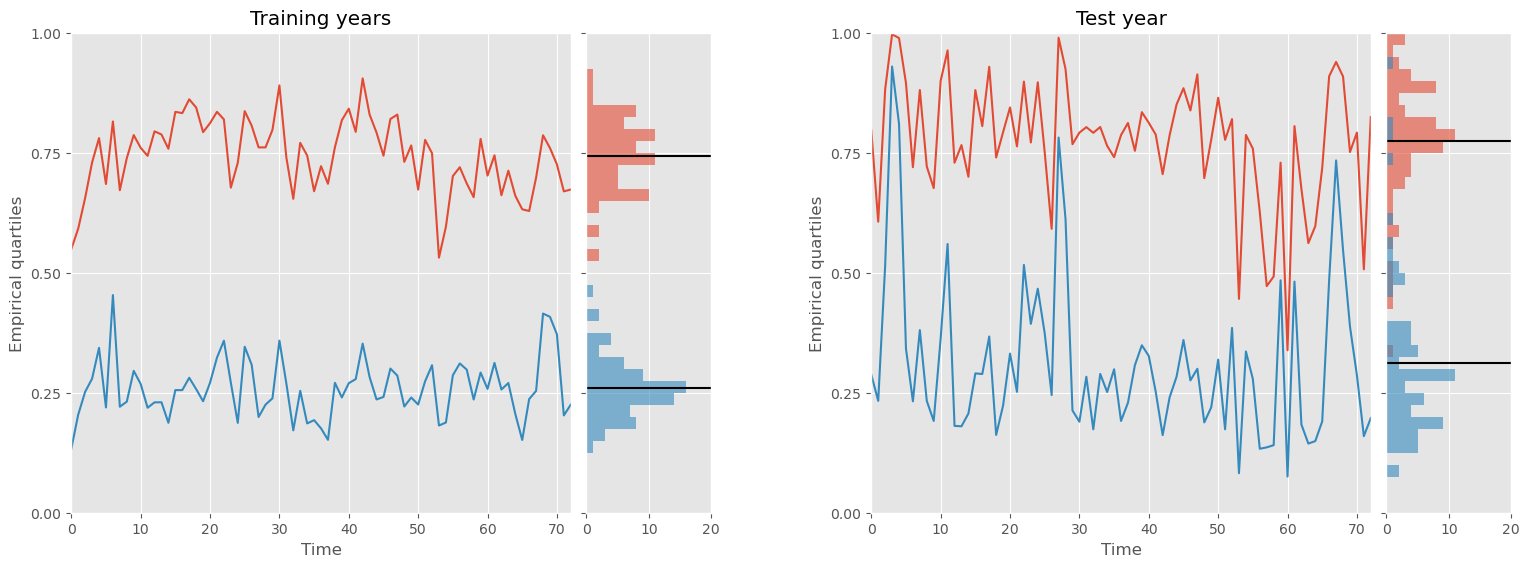

In [54]:
plt.style.use('ggplot')

def plot_and_hist(x, y1, y2, ax, ax_histy):

    # no labels
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.plot(x, y1)
    ax.plot(x, y2)
    xmin, xmax = min(x), max(x)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 1)

    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_ylabel("Empirical quartiles")
    ax.set_xlabel("Time")

    # now determine nice limits by hand:
    binwidth = 0.025
    xymax1 = max(np.max(np.abs(x)), np.max(np.abs(y1)))
    lim1 = (int(xymax1/binwidth) + 1) * binwidth
    bins1 = np.arange(-lim1, lim1 + binwidth, binwidth)
    xymax2 = max(np.max(np.abs(x)), np.max(np.abs(y2)))
    lim2 = (int(xymax2/binwidth) + 1) * binwidth
    bins2 = np.arange(-lim2, lim2 + binwidth, binwidth)
    ax_histy.hist(y1, bins=bins1, orientation='horizontal', alpha=0.6)
    ax_histy.hist(y2, bins=bins2, orientation='horizontal', alpha=0.6)

    mean1 = y1.mean()
    ax_histy.hlines(mean1, xmin=0, xmax=20, color='k')
    mean2 = y2.mean()
    ax_histy.hlines(mean2, xmin=0, xmax=20, color='k')
    ax_histy.set_xlim(0, 20)

fig = plt.figure(figsize=(16, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs1 = fig.add_gridspec(1, 2,  width_ratios=(4, 1),
                      left=0.05, right=0.45, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs1[0])
ax_histy = fig.add_subplot(gs1[1], sharey=ax)

plot_and_hist(np.arange(NUM_DATAPOINTS_PER_YEAR), (train_below + train_in) / (train_below + train_in + train_above), train_below / (train_below + train_in + train_above), ax, ax_histy)
ax.set_title("Training years")

gs2 = fig.add_gridspec(1, 2,  width_ratios=(4, 1),
                      left=0.55, right=0.95, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax2 = fig.add_subplot(gs2[0])
ax_histy2 = fig.add_subplot(gs2[1], sharey=ax2)

plot_and_hist(np.arange(NUM_DATAPOINTS_PER_YEAR), (test_below + test_in) / (test_below + test_in + test_above), test_below / (test_below + test_in + test_above), ax2, ax_histy2)

ax2.set_title("Test year")

fig.show()